# Multi-label prediction with fast.ai

Imports

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *

## Importamos y tratamos nuestro dataset

### Importamos los tags

Definimos nuestro dataframe con la informacion de labels de nuestro conjunto de train donde tenemos los tags que queremos predecir

In [3]:
df = pd.read_csv('../data/csv_tags/train_v2.csv')

### Importamos las imagenes

Vamos a generar un DataBunch para tratar las imagenes.DataBunch es un objeto en el que vamos a tener un conjunto de entrenamiento y de validacion. A partir de esta objeto vamos a poder etrenar y ajustar nuestro modelo.

Procedemos a crear las trasnformaciones (tfms) con las que trasnformaremos nuestro dataset.

In [4]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

Como nuestro conjunto de datos son imagenes vamos a asignarilas a un tipo de clase llamada ImageList para poder tratarlas. Vamos a utilizar esta clase y no ImageDataBunch para asegurarnos de tener una correcta loss function para poder manejar nuestro problema multiclass.

En este momento estamos definiendo que vamos a separar un 20% de nuestro conjunto de train de una forma aleatoria para pun conjunto de test (denominado por la libreria como validacion).

In [5]:
np.random.seed(42)
src = (ImageList.from_csv('../data', './csv_tags/train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

C:\Users\Isabel\anaconda3\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


Finalmente trasnformamos nuestro dataset "data" en un DataBunch con las trasnformaciones anteriormente definidas en "tfms". Vamos a determinar el size en 100 para poder hacer las pruebas mas rapido (pese a que Kaggle nos da 256)

In [6]:
data = (src.transform(tfms, size=100).databunch().normalize(imagenet_stats))

Visializamos nuestro DataBunch

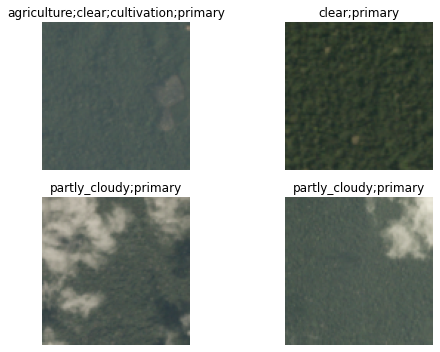

In [7]:
data.show_batch(rows=2, figsize=(8,5))

Podemos ver que nuestros tags estan separados por ;

## Generamos un modelo con resnet18

### Definimos el modelo

ResNet-18 = red neuronal convolucional con 18 capas

In [29]:
arch = models.resnet18

Definimos los parametros que vamos a utilizar:
 - Cada 0.2 threshold vamos a mostrar la precision, se va a utilizar "accuracy_thresh" para poder ir comparando nuestro accuracy en cada threshold. Con esto conseguimos la mayor precision.
 - Se define f_score con fbeta. Se nos devuelve en el threshold anteriormente elegido (0.2) los valores 1 o 2 dependiendo del valor de beta
 - Se definen los parametros de aprendizaje (CNN con una red neuronal resnet18, para mis datos con las metricas anteriormente definidas)

In [16]:
acc_02 = partial(accuracy_thresh, thresh=0.2) 
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Vamos a utilizar LR Finder poder ver cual es un learning rate adecuado para nuestro problema.

In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


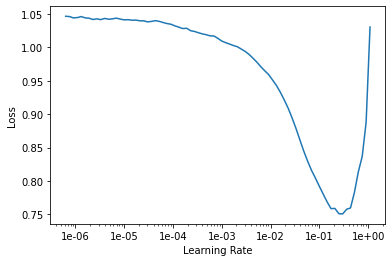

In [18]:
learn.recorder.plot()

Establecemos que nuestro learning rate alrededor de 0.01 por lo visto anteriormente en la grafica.

In [20]:
lr = 0.01

### Entrenamos el modelo

Entrenamos el modelo con 5 epochs

In [21]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.150583,0.130583,0.942499,0.887953,12:44
1,0.119235,0.108152,0.943930,0.906332,11:19
2,0.111495,0.101522,0.947251,0.911380,12:54
3,0.101871,0.096646,0.950049,0.916298,15:16
4,0.101939,0.095590,0.950129,0.916974,15:49


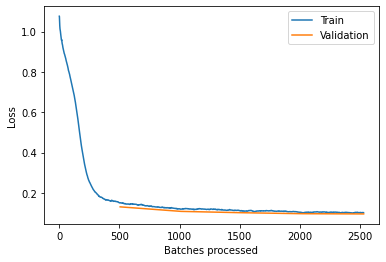

In [22]:
learn.recorder.plot_losses()

In [23]:
learn.save('fastai-rn18')

In [24]:
learn.export()

Obtenemos unos valores de accuracy altos, vamos a ver que precision podemos llegar a tener con una cnn con mas capas y menos iteraciones

## Generamos un modelo con resnet34

### Definimos el modelo

ResNet-34 = red neuronal convolucional con 34 capas

In [28]:
arch2 = models.resnet34

Se definen los parametros de aprendizaje (CNN con una red neuronal resnet50, para mis datos con las metricas anteriormente definidas). Vamos a seguir usando el mismo learning rate

In [31]:
learn2 = cnn_learner(data, arch2, metrics=[acc_02, f_score])

### Entrenamos el modelo

Entrenamos el modelo con 3 epochs, 2 iteraciones menos que las ejecutadas con la cnn resnet18

In [32]:
learn2.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.139490,0.117227,0.942535,0.899743,21:18
1,0.111695,0.101469,0.946917,0.910939,22:09
2,0.105638,0.097040,0.949519,0.915763,24:27


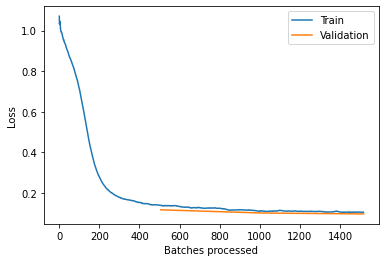

In [33]:
learn2.recorder.plot_losses()

No merece la pena entrenar un modelo con las cnn resnet con mas de 18 capas. Si comparamos los recursos computacionales que estamos empleando en cada iteracion de la red neuronal convolucional con la precicion que obtenemos tenemos que descartar el modelo con la resnet32.

Vamos a probar a crear el modelo con la cnn DenseNet

## Generamos un modelo con densenet121

### Definimos el modelo

In [35]:
arch3 = models.densenet121

Se definen los parametros de aprendizaje (CNN con una red neuronal resnet50, para mis datos con las metricas anteriormente definidas). Vamos a seguir usando el mismo learning rate

In [37]:
learn3 = cnn_learner(data, arch3, metrics=[acc_02, f_score])

Vamos a utilizar LR Finder poder ver cual es un learning rate adecuado para nuestro problema.

In [38]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


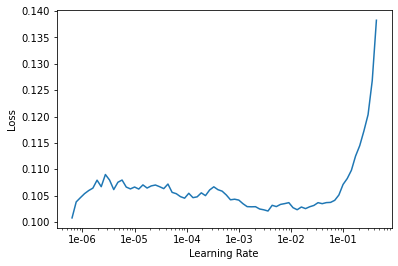

In [39]:
learn.recorder.plot()

Establecemos que nuestro learning rate alrededor de 0.02

In [40]:
lr3 = 0.02

### Entrenamos el modelo

Entrenamos el modelo con 5 epochs, al igual que hicimos con resnet18

In [41]:
learn3.fit_one_cycle(5, slice(lr3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.130403,0.113571,0.948080,0.900540,42:48


KeyboardInterrupt: 

Hemos interrumpido la ejecucion de esta celda ya que podemos ver tras el primer epoch que, al igual que con resnet38, si comparamos los recursos computacionales que estamos empleando en cada iteracion con la precicion que obtenemos tenemos que descartar este modelo.

CONSIDERAMOS QUE EL MEJOR MODELO ES EL REALIZADO CON RESNET-18